In [1]:
import pandas as pd
import numpy as np
import os
import sys
import datetime
import json
import requests
import plotly.express as px
import matplotlib.pyplot as plt
from termcolor import colored                     # coloration du texte
from scipy import stats                           # lois de probabilité (valeurs extrêmes)
from scipy.stats import gumbel_r, genextreme      # valeurs extrêmes
from pyextremes import EVA                        # valeurs extrêmes  
from tabulate import tabulate                     # impression du texte dans un format tabulé
plt.rcParams['text.usetex'] = True                # paramètres latex


plt.rcParams['text.latex.preamble'] = '\\usepackage{libertine}'
plt.rcParams.update({
    "text.usetex": True,
    #"font.family": "Times New Roman",
    "font.family": "Linux Libertine",
    "font.size": 12
})
# from matplotlib import rc
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# rc('text', usetex=True)


from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
#plt.style.use('default')

import arviz as az
import pymc as pm
import pymc_experimental.distributions as pmx
import pytensor.tensor as pt
from arviz.plots import plot_utils as azpu
from scipy.optimize import fsolve
import scipy.optimize as optimize

import seaborn as sns
from scipy.stats import  expon

################################
## Auteur : Christoophe Ancey ##
## Date : novembre 2024       ##
################################

In [2]:
# distribution théorique
distribution_théorique  = expon(loc=0,scale=1)
# Différentes façons de générer un échantillon
# avec numpy
data = np.random.exponential(1, size=100)
# avec scipy
data = distribution_théorique.rvs(size=100)

In [3]:
print(f'Le minimum est {np.min(data):.3f} et le maximum vaut {np.max(data):.2f}')

Le minimum est 0.011 et le maximum vaut 4.73


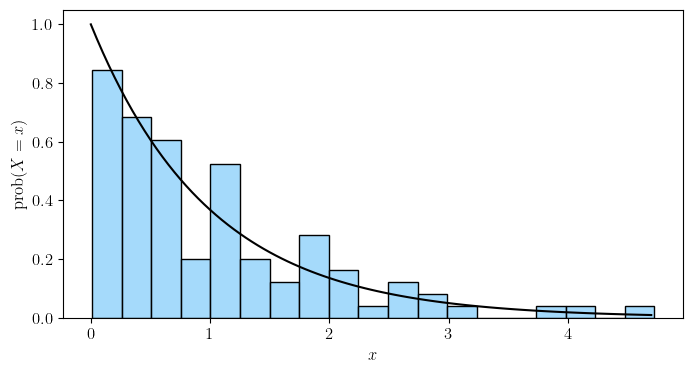

In [4]:
# histogramme + pdf

fig, ax = plt.subplots(figsize=(8,4))
 
# histogramme
sns.histplot(data, ax = ax,  stat = "density", binwidth=0.25, color='lightskyblue'  )
 
plt.xlabel(r'$x$')
plt.ylabel(r'$\mathrm{prob}(X=x)$')

# pdf théorique de la loi de Poisson calée sur les données
 

x = np.arange(0,np.max(data),0.05)
ax.plot(x,  distribution_théorique.pdf(x), color='k',   label='loi exponentielle')

In [5]:
fig.savefig('exemple_exponentielle_pdf.png',dpi=300,bbox_inches='tight')

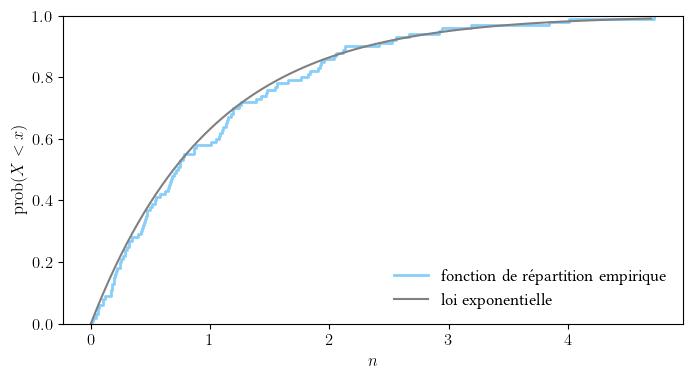

In [6]:
# On trace la fonction de répartition empirique
fig, ax = plt.subplots(figsize=(8,4))

ax.ecdf(data, linewidth = 2, label="fonction de répartition empirique", color='lightskyblue' )


# loi théorique
x = np.arange(0,np.max(data),0.05)
y = distribution_théorique.cdf(x)
ax.plot(x,y,color='grey',label = 'loi exponentielle')

 
ax.set_xlabel(r"$n$")
ax.set_ylabel(r"$\mathrm{prob}(X< x)$")
ax.legend(loc='lower right',frameon=False)

Text(0.9, 0.8, '(b)')

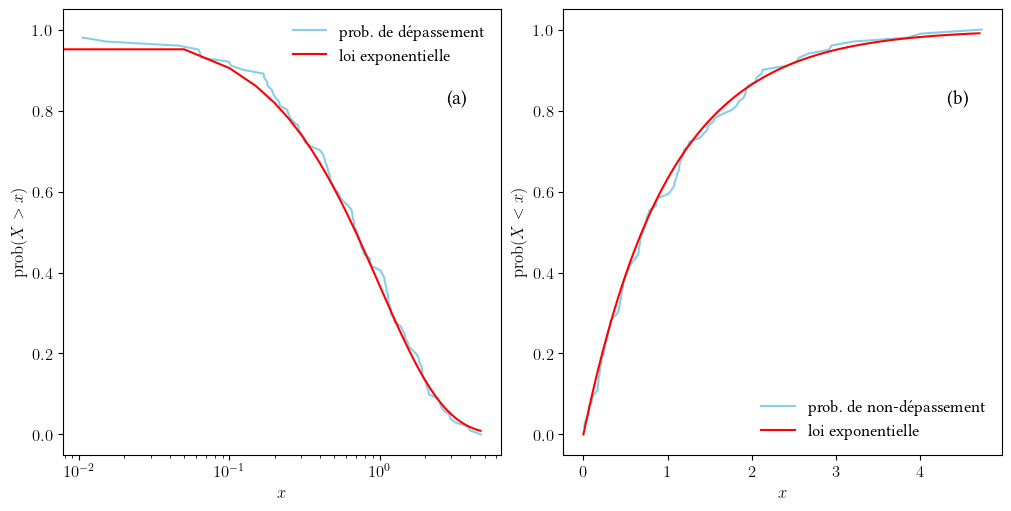

In [7]:
valeurs_triées = np.sort(data )[::-1]
nb_valeurs = len(valeurs_triées)
fréquences_empiriques = [i/(1+nb_valeurs) for i in range(nb_valeurs)]
x = np.arange(0,np.max(data),0.05)
 
fig, ((ax1, ax2) ) = plt.subplots(1, 2, constrained_layout=True)
fig.set_figheight(5)
fig.set_figwidth(5*2)

# On trace la fonction de répartition empirique
ax1.semilogx(valeurs_triées,fréquences_empiriques,label='prob. de dépassement', color='skyblue' )
ax1.set_xlabel(r"$x$ ")
ax1.set_ylabel(r"$\mathrm{prob}(X> x)$")


# loi de exponentielle

y = 1- distribution_théorique.cdf(x)
ax1.plot(x,y,  color='red',label = 'loi exponentielle')
ax1.legend(loc='upper right',frameon=False)

##########
# plot 2 #
##########
# On trace la fonction de répartition empirique
ax2.plot(valeurs_triées,1-np.array(fréquences_empiriques),label='prob. de non-dépassement', color='skyblue' )
ax2.set_xlabel(r"$x$  ")
ax2.set_ylabel(r"$\mathrm{prob}(X<x)$")


# loi de exponentielle

y = distribution_théorique.cdf(x)
ax2.plot(x,y,  color='red',label = 'loi exponentielle')
ax2.legend(loc='lower right',frameon=False)

ax1.text(0.9,0.8,'(a)', horizontalalignment='center',fontsize=14,
     verticalalignment='center',
     transform = ax1.transAxes)
ax2.text(0.9,0.8,'(b)', horizontalalignment='center',fontsize=14,
     verticalalignment='center',
     transform = ax2.transAxes)

In [8]:
fig.savefig('exemple_exponentielle.png',dpi=300,bbox_inches='tight')

Text(0.9, 0.8, '(b)')

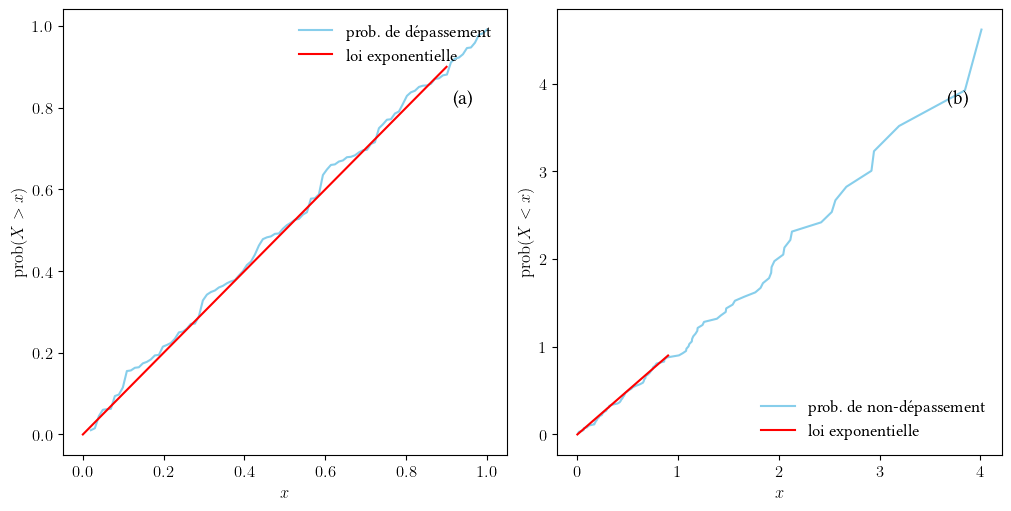

In [14]:
valeurs_triées          = np.sort(data )[::-1]
nb_valeurs              = len(valeurs_triées)
probabilités_empiriques   = [1-i/(1+nb_valeurs) for i in range(nb_valeurs)]
quantiles               = distribution_théorique.ppf(probabilités_empiriques)
probabilités_théoriques = distribution_théorique.cdf(valeurs_triées)

x = np.arange(0,1,0.1)
 
fig, ((ax1, ax2) ) = plt.subplots(1, 2, constrained_layout=True)
fig.set_figheight(5)
fig.set_figwidth(5*2)

# On trace la fonction de répartition empirique
ax1.plot(probabilités_empiriques,probabilités_théoriques,label='prob. de dépassement', color='skyblue' )
ax1.set_xlabel(r"$x$ ")
ax1.set_ylabel(r"$\mathrm{prob}(X> x)$")


# bissectrice

y = x
ax1.plot(x,y,  color='red',label = 'loi exponentielle')
ax1.legend(loc='upper right',frameon=False)

##########
# plot 2 #
##########
# On trace la fonction de répartition empirique
ax2.plot(valeurs_triées,quantiles,label='prob. de non-dépassement', color='skyblue' )
ax2.set_xlabel(r"$x$  ")
ax2.set_ylabel(r"$\mathrm{prob}(X<x)$")


# bissectrice

y = x
ax2.plot(x,y,  color='red',label = 'loi exponentielle')
ax2.legend(loc='lower right',frameon=False)

ax1.text(0.1,0.9,'(a)', horizontalalignment='center',fontsize=14,
     verticalalignment='center',
     transform = ax1.transAxes)
ax2.text(0.1,0.9,'(b)', horizontalalignment='center',fontsize=14,
     verticalalignment='center',
     transform = ax2.transAxes)